In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
from pathlib import Path
from scipy.stats import randint

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV

## 1. Open data and EDA

In [2]:
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: /home/asus/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1


In [3]:
os.listdir(path)

['WA_Fn-UseC_-Telco-Customer-Churn.csv']

In [4]:
file_path = Path(path) / "WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(file_path)

df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# Check target 

df["Churn"].value_counts(normalize=True)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

There is a moderate unbalance.

In [7]:
# Remove not important features

df = df.drop(columns=["customerID"])

In [8]:
# Convert churn to binary

df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

In [9]:
# Treat TotalCharges

df["TotalCharges"].str.strip().eq("").sum()

11

In [10]:
# Conversion to numbers

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

In [11]:
df["TotalCharges"].isnull().sum()

11

Since these are just 11 rows, I could drop them.

In [12]:
df = df.dropna()

## 2. Modelling: Random Forest Classifier

In [13]:
# Separate X and y

X = df.drop("Churn", axis=1)
y = df["Churn"]

In [14]:
# Identification of numerical and categorical variables

numeric_features = ["tenure", "MonthlyCharges", "TotalCharges"]
categorical_features = [col for col in X.columns if col not in numeric_features]

print("Numerical: ", numeric_features)
print("Categorical: ", categorical_features)

Numerical:  ['tenure', 'MonthlyCharges', 'TotalCharges']
Categorical:  ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


The categorical variables need to be modified using one hot encoding.

In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features)
    ]
)

In [18]:
# Pipeline with random forest

rf_pipeline = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("model", RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            class_weight="balanced" # because the dataset is unbalanced
        ))
    ]
)

In [21]:
# Split train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Train X shape: ", X_train.shape)
print("Test X shape: ", X_test.shape)

Train X shape:  (5625, 19)
Test X shape:  (1407, 19)


In [34]:
# Fit and evaluation

rf_pipeline.fit(X_train, y_train)

y_pred = rf_pipeline.predict(X_test)
y_prob = rf_pipeline.predict_proba(X_test)[:, 1]

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("ROC-AUC: ", roc_auc_score(y_test, y_prob))
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred))
print("\nClassification report: \n", classification_report(y_test, y_pred))

Accuracy:  0.7867803837953091
ROC-AUC:  0.8121936004886863
Confusion matrix: 
 [[926 107]
 [193 181]]

Classification report: 
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.63      0.48      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407



## 3. Hyperparameter tuning

In [28]:
param_dist = {
    "model__n_estimators": randint(200, 800),
    "model__max_depth": [None, 10, 20, 30, 40],
    "model__min_samples_leaf": randint(1, 10),
    "model__max_features": ["sqrt", "log2", None]
}

search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist,
    n_iter=30,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['gender',
                                                                                'SeniorCitizen',
                                                                                'Partner',
                                                                                'Dependents',
                                                                                'PhoneService',
                                                                                'MultipleLines',
                                                                                'InternetService',
                                                                                'OnlineSecurity',
                                                                                'OnlineBackup',
                                                                                'DeviceProtection',
                                                                                'TechSupport',
                                                                                'StreamingTV',
                                                                                'StreamingMovies',
                                                                                'Contract'...
                   n_iter=30, n_jobs=-1,
                   param_distributions={'model__max_depth': [None, 10, 20, 30,
                                                             40],
                                        'model__max_features': ['sqrt', 'log2',
                                                                None],
                                        'model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x73958e3ddaf0>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x73958e3df3b0>},
                   random_state=42, scoring='roc_auc')

In [29]:
# Which one is the best model?

best_model = search.best_estimator_
print(search.best_params_)

y_prob = best_model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_prob)

{'model__max_depth': 40, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 9, 'model__n_estimators': 720}


0.8360299941502607

In [31]:
# Check overfitting

print("Train ROC-AUC: ", roc_auc_score(y_train, best_model.predict_proba(X_train)[:, 1]))
print("Test ROC-AUC: ", roc_auc_score(y_test, y_prob))

Train ROC-AUC:  0.9077268862309393
Test ROC-AUC:  0.8360299941502607


The ROC-AUC score is slightly improved with respect to the default case, but there is a slight overfitting.

In [33]:
# Model evaluation

y_pred_best = best_model.predict(X_test)

print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_best))
print("\nClassification report: \n", classification_report(y_test, y_pred_best))

Confusion matrix: 
 [[773 260]
 [ 82 292]]

Classification report: 
               precision    recall  f1-score   support

           0       0.90      0.75      0.82      1033
           1       0.53      0.78      0.63       374

    accuracy                           0.76      1407
   macro avg       0.72      0.76      0.72      1407
weighted avg       0.80      0.76      0.77      1407



With hyperparameter tuning I have improved the capacity of the model to predict churner (from 48% to 78%).

I think that for a company it would be more important to detect churner, that's why I focused on the recall on class 1.

## 4. Precision-recall curves

In [38]:
y_prob = best_model.predict_proba(X_test)[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

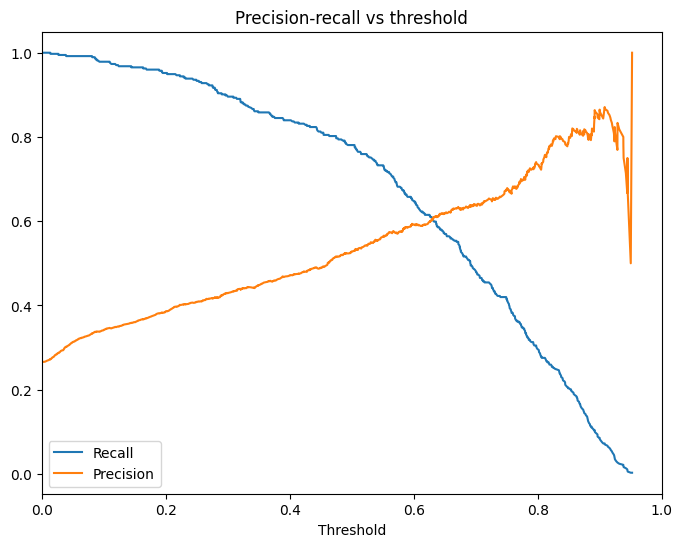

In [40]:
# Visualization of the tradeoff

plt.figure(figsize=(8,6))
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.xlabel("Threshold")
plt.xlim(0,1)
plt.legend()
plt.title("Precision-recall vs threshold")
plt.show()

I assume that I want an higher recall (90%)

In [41]:
target_recall = 0.90

idx = np.where(recalls >= target_recall)[0][-1]
optimal_threshold = thresholds[idx]

optimal_threshold

0.296394254218107

In [42]:
y_custom = (y_prob >= optimal_threshold).astype(int)

In [43]:
print("Confusion matrix: \n", confusion_matrix(y_test, y_custom))
print("\nClassification report: \n", classification_report(y_test, y_custom))

Confusion matrix: 
 [[584 449]
 [ 37 337]]

Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.57      0.71      1033
           1       0.43      0.90      0.58       374

    accuracy                           0.65      1407
   macro avg       0.68      0.73      0.64      1407
weighted avg       0.80      0.65      0.67      1407



Now we are intercepting 90% of churner, but of course there are many more false positives. 